Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
# importing the required libraries
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data is present in google drive so mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
root_dir = "/content/gdrive/MyDrive/CNN_Assignment"
data_dir_train = pathlib.Path(os.path.join(root_dir, "Train"))
data_dir_test = pathlib.Path(os.path.join(root_dir, "Test"))

In [4]:
# print train and test images count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
# define image height, weight and batch_size
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Prepare training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Prepare validation data set. As Test data has only 118 images I am taking 20% records from training data itself.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

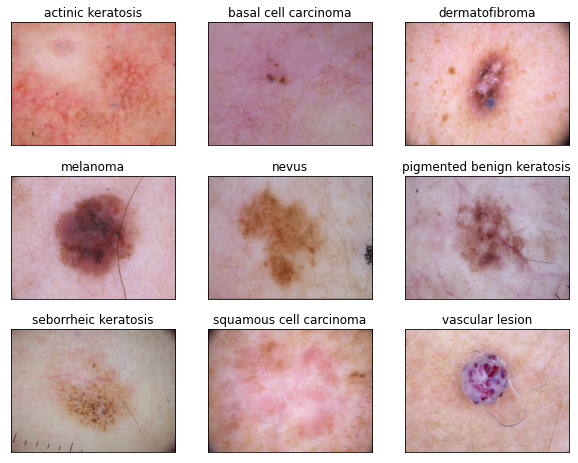

In [9]:
# read the data from train directory and display one image per class
# Per class one images is being diplayed here
fig = plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img_path = os.path.join(data_dir_train, class_names[i])
    img_name = os.listdir(img_path)[0]
    image = plt.imread(os.path.join(img_path, img_name))
    plt.imshow(image)
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Model Architecture

# forming the input shape object
input_shape = (img_height, img_width, 3)

#Sequential allows you to create models layer-by-layer  
model = Sequential()

# normalizing the pixel values between (0,1)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))

# 1st convolution layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattern and Dense Layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
# compiling the model with optimizer as 'adam' and loss function as 'SparseCategoricalCrossentropy'
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 180, 180, 32)     0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 90, 90, 64)       18496     
 pper)                                                  

### Train the model

In [14]:
# Training the model with 20 epocs and batch size of 32
epochs = 20
history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 269s 970ms/step - loss: 2.0831 - accuracy: 0.2271 - val_loss: 1.7721 - val_accuracy: 0.4251
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6765 - accuracy: 0.4208 - val_loss: 1.5009 - val_accuracy: 0.5078
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4986 - accuracy: 0.4766 - val_loss: 1.4045 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4823 - accuracy: 0.4732 - val_loss: 1.3816 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4129 - accuracy: 0.5134 - val_loss: 1.4125 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3588 - accuracy: 0.5240 - val_loss: 1.3748 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2903 - accuracy: 0.5519 - val_loss: 1.3814 - val_accuracy: 0.5101
Epoch 8/20
56/56 [===

### Visualizing training results

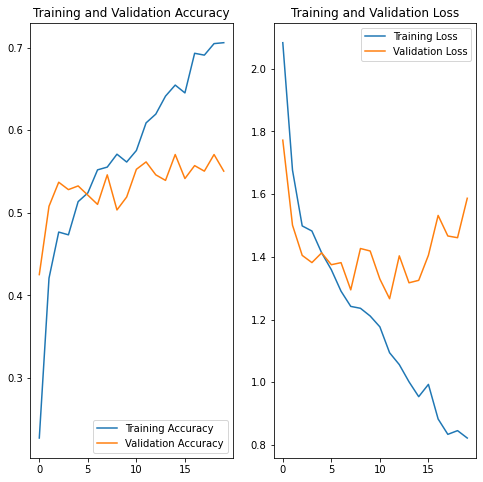

In [15]:
# visualizing the traing and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

By seeing the above Accuracy and Loss plots below are the observations.
1. Training accuracy is having 70% but where in case of validation accuracy it is around 55%. So we can clearly say model is overfitting.
2. Also by looking at the loss plots traing loss is reducing for every epoch but in case of validation its reduced till some point and then its increased again.

So with the above observations we can clearly say that model is overfitting.

#### To overcome the overfitting issue lets use data augumentation techniques and add dropout layer for each convelutional layer. Using horizontal flip, rmadom rotation and random zoom for data augumentation

In [16]:
# Lets create data augumentation strategy
data_augumentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape), # randomly flips images in horizantal
    layers.experimental.preprocessing.RandomRotation(0.1),  # randomly rotates images
    layers.experimental.preprocessing.RandomZoom(0.1) # randomly zooms images
    ])

visualize the augmentation strategy works for one instance of training image.

<Figure size 720x720 with 0 Axes>

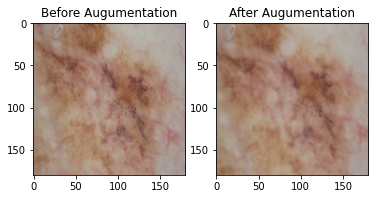

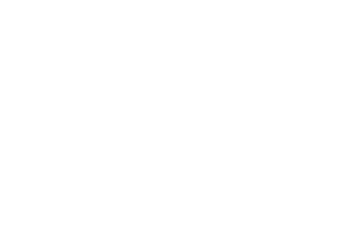

In [17]:
# visualizng the aumentation stragey for one image
# this plots shows before augumentation how the image looks and after augumentation how the image looks
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    augumented_images = data_augumentation(images)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(images[0].numpy().astype("uint8"))
    axarr[0].title.set_text('Before Augumentation')
    axarr[1].imshow(augumented_images[0].numpy().astype("uint8"))
    axarr[1].title.set_text('After Augumentation')
    plt.show()
    plt.axis("off")


### Create the model, compile and train the model


In [18]:
# Creating the Model
#Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

# normalizing the pixel values between (0,1)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))

# adding data augumentation layer
model.add(data_augumentation)

# 1st convolution layer with added droupout
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolution layer with added droupout
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer with added droupout
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compiling the model

In [19]:
# compiling the model with optimizer as 'adam' and loss function as 'SparseCategoricalCrossentropy'
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
# summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_15 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, 180, 180, 32)     0         
 apper)                                                          
                                                                 
 module_wrapper_17 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                      

### Training the model

In [21]:
# Training the model with 20 epocs and batch size of 32
epochs = 20
history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 5s 67ms/step - loss: 2.2934 - accuracy: 0.1847 - val_loss: 2.0921 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0459 - accuracy: 0.1908 - val_loss: 2.0713 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0288 - accuracy: 0.2031 - val_loss: 2.0431 - val_accuracy: 0.2282
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0248 - accuracy: 0.1908 - val_loss: 2.0309 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 1.9969 - accuracy: 0.2355 - val_loss: 1.9577 - val_accuracy: 0.2819
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.8407 - accuracy: 0.3320 - val_loss: 1.7002 - val_accuracy: 0.3960
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6955 - accuracy: 0.3878 - val_loss: 1.7650 - val_accuracy: 0.3736
Epoch 8/20
56

### Visualizing the results

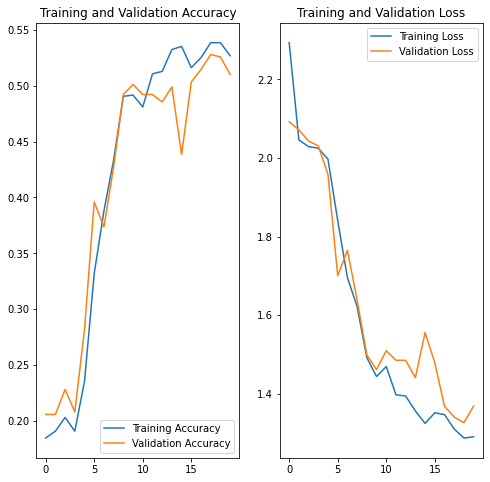

In [22]:
# visualizing the traing and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

By seeing the above plots below are the observations.
1. Training data is having accuracy of 52% and Validation data is having accuracy of 51% are almost near to each other, but accuracy of the model is low compared to previous model.
2. Training and Validation loss also following same pattern of decreasing loss.

So in this step we solved overfitting issue but accuracy is low. To increase accuracy we will follow below steps.


####Plot the distribution of the data
####Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

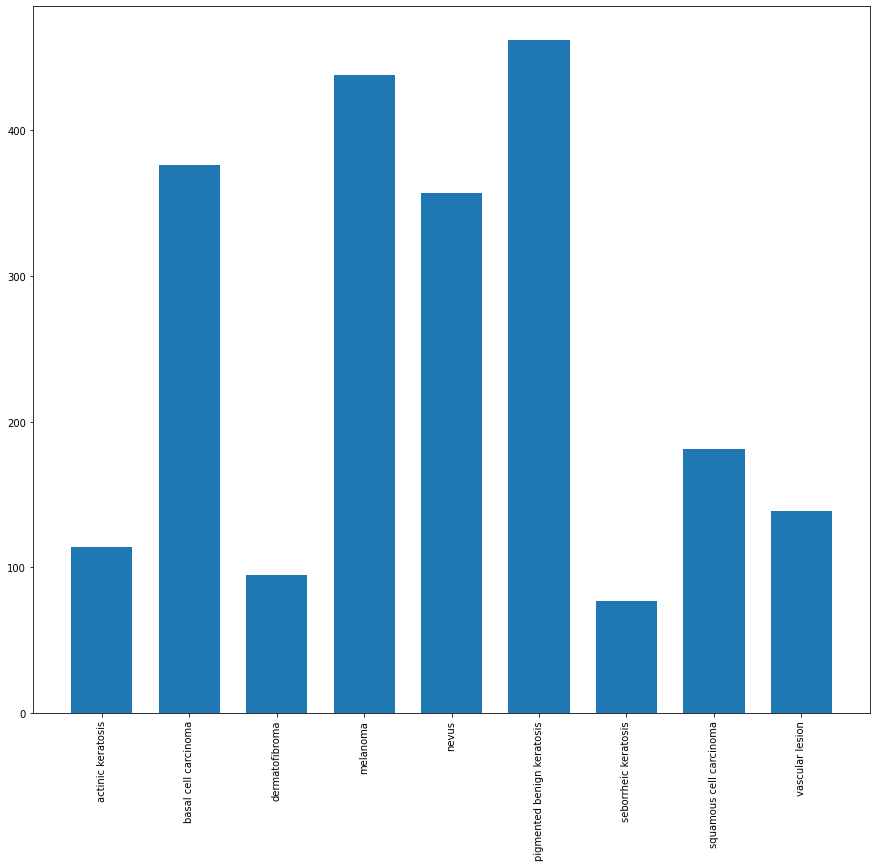

In [24]:
# plotting the number of records present in each class of images
train_ds_dir_count = dict()
for i in range(len(class_names)):
    dir_name = os.path.join(data_dir_train, class_names[i])
    train_ds_dir_count[class_names[i]] = len(os.listdir(dir_name))

names = list(train_ds_dir_count.keys())
values = list(train_ds_dir_count.values())

plt.figure(figsize=(15,13)) 
plt.bar(range(len(train_ds_dir_count)), values, tick_label=names, width = 0.7)
plt.xticks(rotation=90)
plt.show()

#### The below arethe finding based on the above plot
#### - Which class has the least number of samples?
        Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
        pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F605684CF10>: 100%|██████████| 500/500 [00:20<00:00, 24.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6054165E90>: 100%|██████████| 500/500 [00:21<00:00, 23.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F60541656D0>: 100%|██████████| 500/500 [00:21<00:00, 22.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6054061110>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F6054057DD0>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F605437DCD0>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6056EF7C90>: 100%|██████████| 500/500 [00:41<00:00, 12.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6056840F90>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F605683C850>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_439032cf-121a-4757-bee3-466b783b59a1.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_44881349-10e5-49f6-b904-7628d0caf324.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_a6ec7318-fab6-469e-a71a-8b998ba67e97.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025980.jpg_59abca50-8acc-4ae2-80a9-a2065369b64b.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_46856094-e31a-493f-8719-2533ff37ed20.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_3800d364-81b9-4ebc-acf1-89a41d29e2bb.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Train/dermatofibroma/output/dermatofibrom

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [33]:
new_df['Label'].value_counts()

dermatofibroma                500
melanoma                      500
actinic keratosis             500
seborrheic keratosis          500
nevus                         500
vascular lesion               500
squamous cell carcinoma       500
pigmented benign keratosis    500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [47]:
# creating training data
data_dir_train= os.path.join(root_dir, 'Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
# creating validation data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

with addition to data augumentation we are adding BatchNormalization and L2 regularizaion also

In [56]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

# normalizing the pixel values between (0,1)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))

# 1st convolution layer with BatchNormalization and Dropout
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolution layer with BatchNormalization and Dropout
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer with BatchNormalization and Dropout
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th convolution layer with BatchNormalization and Dropout
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense layer with l2 regularization
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
# compiling the model with optimizer as 'adam' and loss function as 'SparseCategoricalCrossentropy'
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
# print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_108 (ModuleW  (None, 180, 180, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_109 (ModuleW  (None, 180, 180, 32)     0         
 rapper)                                                         
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 module_wrapper_110 (ModuleW  (None, 90, 90, 32)       0         
 rapper)                                             

#### **Todo:**  Train your model

In [54]:
# training the model with 30 epocs and with batch size of 32
epochs = 30
history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 34s 189ms/step - loss: 7.8118 - accuracy: 0.2426 - val_loss: 12.9971 - val_accuracy: 0.1299
Epoch 2/30
169/169 [==============================] - 34s 195ms/step - loss: 1.9804 - accuracy: 0.2474 - val_loss: 6.3670 - val_accuracy: 0.1923
Epoch 3/30
169/169 [==============================] - 34s 197ms/step - loss: 1.8519 - accuracy: 0.2925 - val_loss: 4.9581 - val_accuracy: 0.2947
Epoch 4/30
169/169 [==============================] - 33s 188ms/step - loss: 1.7748 - accuracy: 0.3203 - val_loss: 1.6367 - val_accuracy: 0.3890
Epoch 5/30
169/169 [==============================] - 33s 188ms/step - loss: 1.6744 - accuracy: 0.3485 - val_loss: 1.9250 - val_accuracy: 0.3653
Epoch 6/30
169/169 [==============================] - 33s 187ms/step - loss: 1.6800 - accuracy: 0.3424 - val_loss: 1.5745 - val_accuracy: 0.3890
Epoch 7/30
169/169 [==============================] - 33s 188ms/step - loss: 1.6097 - accuracy: 0.3637 - val_loss: 1.5608 - val_a

#### **Todo:**  Visualize the model results

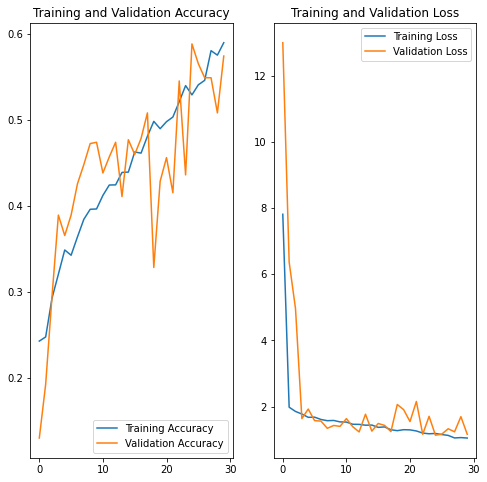

In [55]:
# visualizing the traing and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The below are  the observations for the given data set.
1. Initially the model is Overfitting.
2. After adding Augumentation and Dropouts model overfitting issue is solved but model accuracy is reduced. To overcome this data augumentation and batch Normalization and l2 regularization is added.
3. After Data Augumentor, Normalization and l2 regularization and extra layer model accuracy is improved and model underfitting issue also solved. 